## Policy improvement without enviorement interaction

In [2]:
import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from crowd_nav.imitate import *
from crowd_nav.utils.multi_envs import modify_env_params
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
import copy
from crowd_nav.multi_env.improvement import *

In [3]:
def model_from_path(model_path) :
    policy_p = 'configs/policy.config'
    # configure policy
    policy = policy_factory['sail_traj_simple']()
    policy_config = configparser.RawConfigParser()
    policy_config.read(policy_p)
    policy.configure(policy_config)
    
    model = policy.model
    model.load_state_dict(torch.load(model_path))
    return model

In [3]:
model_path = 'data/full_data_tests/trajpred/imitate-trajpred-2.50-weight-1to4-length-traj/policy_net_129.pth'
traj_path = 'data/full_data_tests/trajpred/imitate-trajpred-2.50-weight-1to4-length-traj/prediction_head_129.pth'

model = model_from_path(model_path)
prediction_head = torch.load(traj_path).to('cpu')

In [4]:
t_fex = model.trajectory_fext.to('cpu')

In [5]:
l = os.listdir('data/improvement/temp/')

In [6]:
data = torch.load('data/improvement/temp/{}/data.pth'.format(l[10]))

In [7]:
exp = data['experience']
results = data['results']
env_mods = data['env_mods']

In [8]:
env_mods, results

({'safety_space': 0.5526262626262627,
  'neighbor_dist': 4.344827586206897,
  'time_horizon': 1.1111111111111112},
 {'success': 0.756,
  'collision': 0.22,
  'nav time': 11.701719576719576,
  'reward': 0.1966625692086394,
  'traj accuracy': 0.013479266856660179})

In [9]:
ds = exp_to_ds(exp)

In [10]:
test_traj_acc(ds, t_fex, prediction_head)

0.01157091397255494

In [11]:
models = train_traj(ds, t_fex, prediction_head, device='cpu', n_epochs=30, batch_size=256)

Epoch 0 loss 0.0076


Epoch 5 loss 0.0057


Epoch 10 loss 0.0054


Epoch 15 loss 0.0052


Epoch 20 loss 0.0050


Epoch 25 loss 0.0049


In [12]:
results_ep = []
for i, (tf, ph) in enumerate(models) :
    if i % 1 == 0 :
        loss = test_traj_acc(ds, tf, prediction_head)
        res = test_model(m_p=None, model_type='sail_traj_simple', visible=False, n_episodes=100,\
               env_type='orca', traj_path=traj_path, env_mods=env_mods, model=model, return_exp=True, t_fex=tf, pred_head=ph)

    results_ep.append((loss, res))

success: 0.7800,collision: 0.1800,nav time: 11.88,reward: 0.2128, timeout : 0.0400, traj accuracy : 0.0068


success: 0.7800,collision: 0.1800,nav time: 12.23,reward: 0.2076, timeout : 0.0400, traj accuracy : 0.0066


success: 0.7900,collision: 0.1600,nav time: 12.16,reward: 0.2147, timeout : 0.0500, traj accuracy : 0.0063


success: 0.7800,collision: 0.1800,nav time: 12.25,reward: 0.2101, timeout : 0.0400, traj accuracy : 0.0062


success: 0.7800,collision: 0.1700,nav time: 12.36,reward: 0.2078, timeout : 0.0500, traj accuracy : 0.0065


success: 0.7700,collision: 0.1900,nav time: 12.23,reward: 0.2053, timeout : 0.0400, traj accuracy : 0.0063


success: 0.7400,collision: 0.2200,nav time: 12.07,reward: 0.1973, timeout : 0.0400, traj accuracy : 0.0067


success: 0.7300,collision: 0.1900,nav time: 12.08,reward: 0.1972, timeout : 0.0800, traj accuracy : 0.0066


success: 0.7100,collision: 0.2300,nav time: 12.08,reward: 0.1890, timeout : 0.0600, traj accuracy : 0.0073


KeyboardInterrupt: 

mods = {'safety_space': 0.18, 'neighbor_dist': 1.24,'time_horizon': 5.55}
res, exp = test_model(m_p=None, model_type='sail_traj_simple', visible=False, n_episodes=3000,\
           env_type='orca', traj_path=traj_path, env_mods=mods, model=model, return_exp=True)

In [5]:
#mods = {'safety_space': 0.18, 'neighbor_dist': 1.24,'time_horizon': 5.55}
#res, exp = test_model(m_p=None, model_type='sail_traj_simple', visible=False, n_episodes=10000,\
#           env_type='orca', traj_path=traj_path, env_mods=mods, model=model, return_exp=True)
#ds = exp_to_ds(exp)
#torch.save(ds, 'data/outlier/experience.pth')

success: 0.79, collision: 0.21, nav time: 10.42, reward: 0.2359 +- 0.1993, traj accuracy : 0.0228

In [6]:
ds = torch.load('data/outlier/experience.pth')

In [7]:
test_traj_acc(ds, t_fex, prediction_head)

Loss 0.0215


0.021526210613573266

In [12]:
count = 0 
for root, dirs, _ in os.walk('data/improvement/temp/') :
    for d in dirs :
        if count == 0 :
            continue
        count += 1
        path = os.path.join(root, d)
        rs = os.path.join(path, 'results.pth')
        ms = os.path.join(path, 'models.pth')
        if os.path.exists(rs) :
            os.remove(rs)
        if os.path.exists(ms) :
            os.remove(ms)

In [8]:
models = train_traj(ds, t_fex, prediction_head, device='cpu', n_epochs=4, batch_size=256)

Epoch 0 loss 0.0170


Epoch 1 loss 0.0152


Epoch 2 loss 0.0145


Epoch 3 loss 0.0141


In [9]:
for tf, ph in models :
    test_traj_acc(ds, tf, ph)

Loss 0.0156


Loss 0.0148


Loss 0.0143


Loss 0.0138


In [10]:
results = []
mods = {'safety_space': 0.18, 'neighbor_dist': 1.24,'time_horizon': 5.55}
for tf, ph in models :
    loss = test_traj_acc(ds, tf, prediction_head)
    res = test_model(m_p=None, model_type='sail_traj_simple', visible=False, n_episodes=100,\
           env_type='orca', traj_path=traj_path, env_mods=mods, model=model, return_exp=True, t_fex=tf, pred_head=ph)
    
    results.append((loss, res))

Loss 0.0169


success: 0.86, collision: 0.14, nav time: 10.62, reward: 0.2686 +- 0.1715, traj accuracy : 0.0175


Loss 0.0153


success: 0.87, collision: 0.13, nav time: 10.55, reward: 0.2759 +- 0.1659, traj accuracy : 0.0167


Loss 0.0143


success: 0.90, collision: 0.10, nav time: 10.66, reward: 0.2867 +- 0.1509, traj accuracy : 0.0159


Loss 0.0138


success: 0.89, collision: 0.11, nav time: 10.61, reward: 0.2853 +- 0.1566, traj accuracy : 0.0154


## Plots

In [19]:
import pandas as pd

In [6]:
results = []
root = 'data/improvement/temp/'
env_dirs = os.listdir(root)
for env_dir in env_dirs :
    env_dir = os.path.join(root, env_dir)
    res = torch.load(os.path.join(env_dir, 'results.pth'))
    results.append(res)    

In [28]:
results[0]

{'env_mods': {'safety_space': 0.5685858585858586,
  'neighbor_dist': 0.20689655172413793,
  'time_horizon': 1.1111111111111112},
 'init_results': {'success': 0.83,
  'collision': 0.17,
  'nav time': 9.62710843373494,
  'reward': 0.27709384811255344,
  'traj accuracy': 0.013589969935940263},
 'result_per_epoch': [(0,
   {'success': 0.805,
    'collision': 0.195,
    'nav time': 9.583850931677018,
    'reward': 0.2652847009938653,
    'traj accuracy': 0.007587215406876884}),
  (1,
   {'success': 0.84,
    'collision': 0.16,
    'nav time': 9.55952380952381,
    'reward': 0.285425618366147,
    'traj accuracy': 0.006747685367552846}),
  (2,
   {'success': 0.845,
    'collision': 0.155,
    'nav time': 9.559171597633137,
    'reward': 0.2875852128552052,
    'traj accuracy': 0.006415373206775959}),
  (3,
   {'success': 0.845,
    'collision': 0.155,
    'nav time': 9.553254437869823,
    'reward': 0.287716909516591,
    'traj accuracy': 0.006373855924351035}),
  (4,
   {'success': 0.875,
 

In [ ]:
def remove_indexs(indxs, array) :
    for i in indxs :
        array = array[:i] + array[i+1:]

In [12]:
res_diff = []
for res in results :
    res_diff.append({})
    for metric in res['init_results'].keys() :
        init = res['init_results'][metric]
        per_epoch_diff = np.asarray([r[1][metric] for r in res['result_per_epoch']]) - init
        res_diff[-1][metric] = per_epoch_diff

In [37]:
for i, res in enumerate(res_diff) :
    mean_col =  np.mean([x for x in res['collision']])
    if mean_col > 0 : 
        print(results[i]['env_mods'], '{:.3f}'.format(mean_col))

{'safety_space': 0.02595959595959596, 'neighbor_dist': 4.9655172413793105, 'time_horizon': 1.1111111111111112} 0.006
{'safety_space': 0.41696969696969705, 'neighbor_dist': 2.689655172413793, 'time_horizon': 1.1111111111111112} 0.003
{'safety_space': 0.04989898989898991, 'neighbor_dist': 1.8620689655172413, 'time_horizon': 7.777777777777779} 0.013
{'safety_space': 0.01797979797979798, 'neighbor_dist': 1.6551724137931034, 'time_horizon': 10.0} 0.009
{'safety_space': 0.3212121212121213, 'neighbor_dist': 5.379310344827586, 'time_horizon': 5.555555555555555} 0.007
{'safety_space': 0.5526262626262627, 'neighbor_dist': 4.344827586206897, 'time_horizon': 1.1111111111111112} 0.005


In [38]:
for i, res in enumerate(res_diff) :
    mean_col =  np.mean([x for x in res['collision']])
    if mean_col <0 : 
        print(results[i]['env_mods'], '{:.3f}'.format(mean_col))

{'safety_space': 0.5685858585858586, 'neighbor_dist': 0.20689655172413793, 'time_horizon': 1.1111111111111112} -0.064
{'safety_space': 0.3132323232323233, 'neighbor_dist': 3.7241379310344827, 'time_horizon': 6.666666666666667} -0.015
{'safety_space': 0.32919191919191926, 'neighbor_dist': 0.20689655172413793, 'time_horizon': 8.88888888888889} -0.068
{'safety_space': 0.432929292929293, 'neighbor_dist': 3.9310344827586206, 'time_horizon': 5.555555555555555} -0.038
{'safety_space': 0.41696969696969705, 'neighbor_dist': 4.137931034482759, 'time_horizon': 2.2222222222222223} -0.001
{'safety_space': 0.5286868686868688, 'neighbor_dist': 3.9310344827586206, 'time_horizon': 2.2222222222222223} -0.028
{'safety_space': 0.7521212121212122, 'neighbor_dist': 0.20689655172413793, 'time_horizon': 10.0} -0.054
{'safety_space': 0.36909090909090914, 'neighbor_dist': 0.20689655172413793, 'time_horizon': 6.666666666666667} -0.049
{'safety_space': 0.3531313131313132, 'neighbor_dist': 2.2758620689655173, 'tim

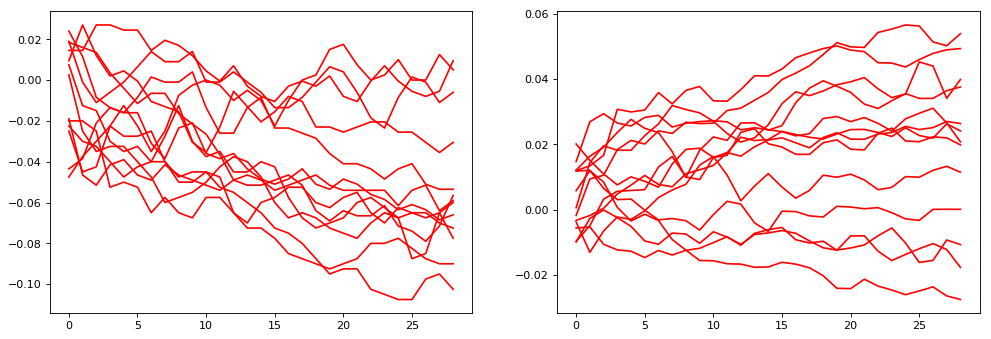

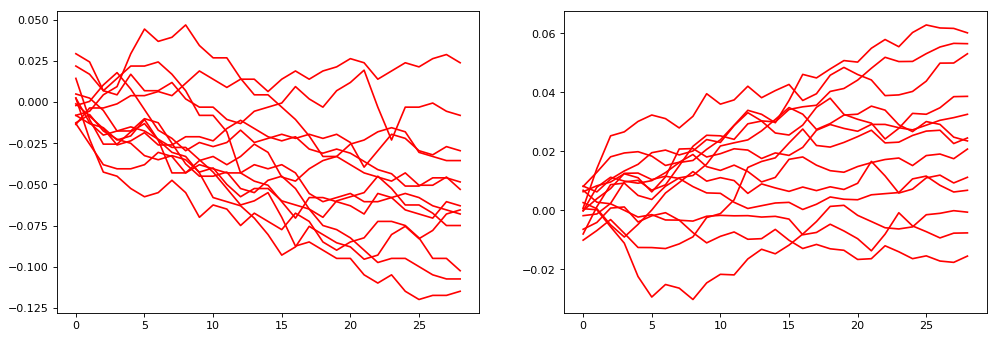

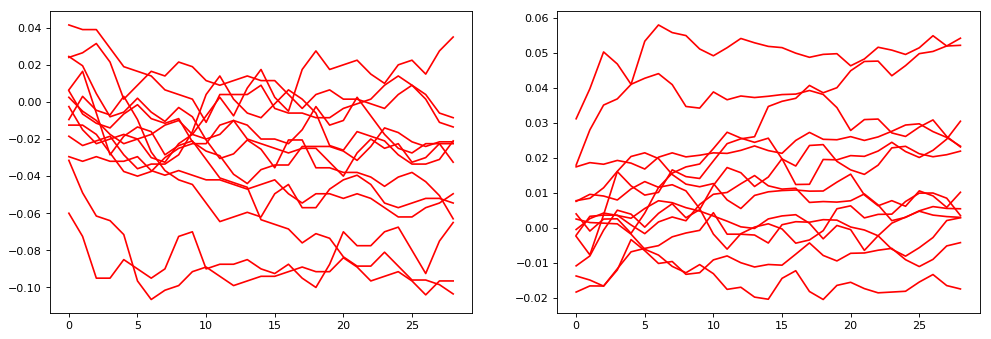

In [27]:
metrics = ['collision', 'reward']
for i in range(3) :
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=80, figsize=(15, 5))
    for met, ax in zip(metrics, [ax1, ax2]) :
        split = int(len(res_diff)/3)
        for res in res_diff[(i*split):((i+1)*split)] :
            y = np.convolve(res[met], np.ones(2)/2, mode='valid')
            ax.plot(range(len(y)), y, c='r')
    plt.show()

In [41]:
for res in results :
    res['last_epochs_res'] = {}
    for met in res['init_results'].keys() :
        avg = np.mean([r[1][met] for r in res['result_per_epoch']][-5:])
        res['last_epochs_res'][met] = avg

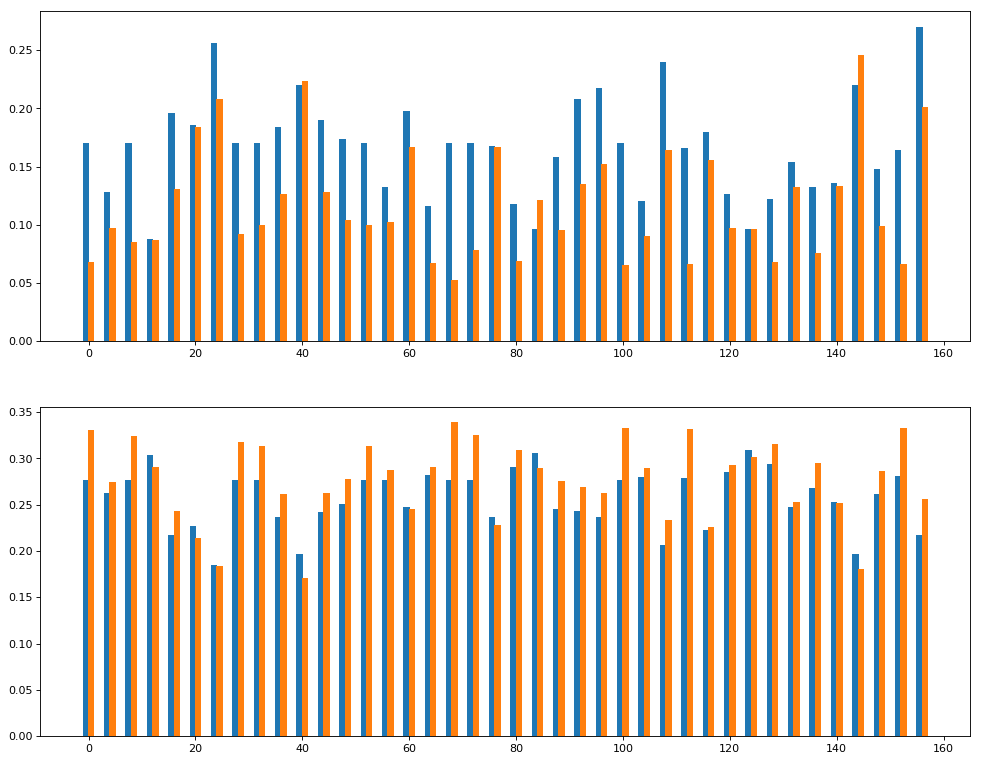

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=80, figsize=(15, 12))
for met, ax in zip(metrics, [ax1, ax2]) :
    split = int(len(res_diff)/3)
    init_res = [res['init_results'][met] for res in results]
    avg_res = [res['last_epochs_res'][met] for res in results]
    scale = 2
    width = 0.5 * 2.4
    x = np.arange(len(avg_res)) * 2 * scale
    ax.bar(x - 0.25*scale, init_res, width=width)
    ax.bar(x + 0.25*scale, avg_res, width=width)
plt.show()